In [1]:
from mssa.mssa import mSSA
import pandas as pd 
import matplotlib.pyplot as plt 
import io
import numpy as np 
import torch 
import copy 
from sklearn.metrics import r2_score
import os 
dev = False

In [2]:
file = "LD2011_2014_clean.txt"
isExist = os.path.exists(file)
if not isExist:
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
    !unzip LD2011_2014.txt.zip
    # change commas to dots
    !sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt
else: 
    print(f"Files are ready")

Files are ready


In [3]:
"""Preprocess data"""
data = pd.read_csv('LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('Data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
aggregated_data = data_2.groupby(['time']).agg(agg_dict)
print('Data aggregated by hour')
aggregated_data.shape

Data loaded..
Data aggregated by hour


(26304, 370)

In [4]:
aggregated_data.shape

(26304, 370)

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

In [69]:
normalized_data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,-0.767048,5.979015,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,-0.925467,-0.660711,-0.611351,-0.924599,-1.182866,0.055241,-0.298429,-0.970811,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,1.174705,2.419487,0.131533,0.362440,0.666522,1.016322,...,-0.968145,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,5.979015,0.710631,0.964851,1.573172,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,-0.289139,-0.478750,-1.119708,-1.044284,-1.312616
2012-01-01 04:00:00,-0.088516,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,-0.559453,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,-1.139759,-0.289139,-1.696712,-1.175544,-1.102634,-1.312616
2012-01-01 05:00:00,-0.141076,-0.905502,5.979015,-0.726679,-0.259294,-0.524736,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,-0.961790,-1.182866,-0.383061,-1.707784,-1.169340,-1.072133,-1.312616


In [7]:
if dev:
    cols = normalized_data.columns

In [8]:
if dev:
    test_df = normalized_data.iloc[:5][cols[:5]].copy()
    np_test = test_df.to_numpy()

In [9]:
if dev:
    """Inject missing data"""
    # Convert original data to 1d array - Because existing package only supports randomly choose from 1d array
    np_test_1d = np_test.flatten()
    np_test_1d

In [10]:
if dev:
    total_elem = np_test_1d.shape[0]
    missing_percentage = 50
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100) 
    print(number_of_missing_elem)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False)
    np_test_1d[missing_index] = 0
    np_test_1d

In [11]:
if dev:
    np_test_2d = np_test_1d.reshape(5,-1)
    np_test_2d

In [70]:
"""

Create missing values based on normal distribution random choice

Input: 
 - pd_data: 2d pandas data frame
 - missing_percentage: missing percentage <= 100

Output:
 - return_data: 2d pandas with missed values

"""
def create_missing_data(pd_data, missing_percentage = 20):
    if missing_percentage == 0: return pd_data
    assert missing_percentage <= 100, "missing percentage should be less than or equal 100%"
    np.random.seed(1993)
    # Convert data frame to array
    np_data = pd_data.to_numpy()
    # Convert original data to 1d array - Because existing package only supports to randomly choose indices from 1d array
    np_data_1d = np_data.flatten()
    # Randomly choose missing index
    total_elem = np_data_1d.shape[0]
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False) # with replace = False, an index only is chosen 1 time
    # Replace missing_index with 0
    np_data_1d[missing_index] = 0
    # Convert 1d array to 2d array
    np_data_2d = np_data_1d.reshape(pd_data.shape[0], pd_data.shape[1])
    # Convert 2d array to dataframe
    cols_name = pd_data.columns
    return_data = pd.DataFrame(np_data_2d, columns = cols_name)
    return_data.index = pd_data.index
    return return_data

missing_df = create_missing_data(normalized_data, missing_percentage=20)
missing_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,0.000000,0.000000,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,0.000000,-0.660711,-0.611351,-0.924599,-1.182866,0.000000,-0.298429,0.000000,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,0.000000,0.000000,0.131533,0.362440,0.000000,1.016322,...,0.000000,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,0.000000,0.710631,0.000000,0.000000,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,0.000000,0.000000,-1.119708,-1.044284,0.000000
2012-01-01 04:00:00,0.000000,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,0.000000,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,0.000000,-0.289139,0.000000,-1.175544,0.000000,-1.312616
2012-01-01 05:00:00,0.000000,-0.905502,5.979015,-0.726679,-0.259294,0.000000,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,0.000000,-1.182866,0.000000,-1.707784,-1.169340,0.000000,-1.312616


In [7]:
global n_clients; global data_train; global data_test
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:25968,:n_clients] #25600; 25968; 26082
    data_test = normalized_data.iloc[25968:,:n_clients]
    return data_train, data_test

In [8]:
data_train, data_test = set_train_test(n_clients=370)
data_train.shape, data_test.shape

((25968, 370), (336, 370))

In [9]:
def get_flattened_obs(data_train, L=80):
    df = data_train
    N = df.shape[1]
    col_to_row_ratio = 4

    T = df.shape[0]

    M = int(df.size / L)
    if M%N != 0:
        M -= M%N
    M_ts = M // N
    # inc_obs = np.array(df.iloc[:M_ts*L,:]) # first range, we use second range for traning
    inc_obs = np.array(df.iloc[T%L:,:]) # second range, note its not T%L+1 due to python index
    normalize = False
    from sklearn.preprocessing import StandardScaler
    if normalize:
        scaler = StandardScaler()
        inc_obs = scaler.fit_transform(inc_obs)
        norm_means = scaler.mean_
        norm_std = scaler.scale_

    flattened_obs = inc_obs.reshape([L,M], order = 'F') # 按照列顺序
    # flattened_obs = flattened_obs[:,np.arange(M_ts*self.no_ts).reshape([self.no_ts,M_ts]).flatten('F')] # 这里导致第二列是ts2，stacked page是不同ts交错组成
    return flattened_obs, M_ts

In [10]:
global N; global M_ts; global L; global window
L = 80
flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
window = M_ts

In [11]:
days = 1
predictions = np.zeros((len(data_test.columns),24*days))
ub = np.zeros((len(data_test.columns),24*days))
lb = np.zeros((len(data_test.columns),24*days))

predictions.shape

(370, 24)

In [12]:
def predict_one_day(data_test, model, weights, days=7):
    # predict for seven days
    # days = 7

    #initialise prediction array
    predictions = np.zeros((len(data_test.columns),24*days))
    ub = np.zeros((len(data_test.columns),24*days))
    lb = np.zeros((len(data_test.columns),24*days))

    # specify start time
    start_time = pd.Timestamp('2014-12-18 01:00:00')

    # actual = data_test.values[:24*days,:]

    # obtain new actual by index, new test start from 2014-12-02-17:00
    actual = data_test[data_test.index>=start_time].values[:24*days,:]


    for day in range(days):
        # get the final time stamp in the day
        end_time = start_time + pd.Timedelta(hours=23)
        # convert timestamps to string
        start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
        end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
        # predict for each house
        for i, column in enumerate(data_test.columns):
            # Forecast
            df_30 = model.predict(column,start_str,end_str)
            predictions[i,day*24:(day+1)*24] = df_30['Mean Predictions']
            ub[i,day*24:(day+1)*24] = df_30['Upper Bound']
            lb[i,day*24:(day+1)*24] = df_30['Lower Bound']

        # fit the model with the already predicted values 

        # df_insert = data_test.iloc[day*24:24*(day+1),:]

        # obtain new df_insert
        # df_insert = data_test[data_test.index>=start_time].iloc[day*24:24*(day+1),:]

        # model.update_model(df_insert)
    
        if weights is not None:
            model.ts_model.models[0].weights = weights

        # update start_time
        start_time = start_time + pd.Timedelta(hours=24)
    return actual, predictions

In [14]:
def test_sd(data_train, data_test, L, n_users, M_ts, dim, days, plot_all, plot_single):
    data_train = data_train.iloc[:,:n_users] # Debug1
    data_test = data_test.iloc[:,:n_users]

    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
    # stand-alone ssa
    window = M_ts
    lst_U_sd = []
    for i in range(n_users):
        data = flattened_obs[:,i*window:(i+1)*window]
        U,_,_ = np.linalg.svd(data)
        U = U[:,:dim]
        lst_U_sd.append(U)

    P_sd = flattened_obs
    P_sd_hat = []
    y_sd = []
    y_true = P_sd[-1,:]
    P_tilde_sd_hat = []
    imputation_model_score_sd = []
    actual = []; predictions_sd = []
    from sklearn.linear_model import LinearRegression
    
    for i in range(n_users):
        P_i_sd = P_sd[:,int(i*window):int((i+1)*window)]
        P_i_sd_hat = lst_U_sd[i].dot(lst_U_sd[i].T.dot(P_i_sd)); P_sd_hat.append(P_i_sd_hat)
        y_i_sd = P_i_sd_hat[-1,:]; y_sd.append(y_i_sd)
        y_i_true = P_i_sd[-1,:]
        P_i_tilde_sd_hat = P_i_sd_hat[:-1,:]; P_tilde_sd_hat.append(P_i_tilde_sd_hat)
        imputation_model_score_sd.append(r2_score(P_i_sd.flatten('F'),P_i_sd_hat.flatten('F'))) # verified same as imputation_model_score)
        # prediction
        reg = LinearRegression(fit_intercept=False).fit(P_i_tilde_sd_hat.T, y_i_sd)
        weights_sd_i = reg.coef_
        model_sd = mSSA(rank = dim, normalize = False, L=L)
        model_sd.update_model(pd.DataFrame(data_train.iloc[:,i]))
        model_sd.ts_model.models[0].weights = weights_sd_i
        actual_i, predictions_sd_i = predict_one_day(pd.DataFrame(data_test.iloc[:,i]), model_sd, weights_sd_i)
        actual.append(actual_i); predictions_sd.append(predictions_sd_i.T)
    imputation_model_score_sd = np.array(imputation_model_score_sd)
    P_sd_hat = np.hstack(P_sd_hat)
    y_sd = np.hstack(y_sd)
    P_tilde_sd_hat = np.hstack(P_tilde_sd_hat)
    actual = np.hstack(actual); predictions_sd = np.hstack(predictions_sd)
    print("imputation score:", imputation_model_score_sd.mean())
    
    Y = actual[:,:]
    Y_h_sd = predictions_sd[:,:]
    mse_sd = np.sqrt(np.mean(np.square(Y[:24*days]-Y_h_sd[:24*days]))) # Debug2
    y_true = Y[:24*days]
    y_pred = Y_h_sd[:24*days]
    print('Forecasting accuracy (RMSE) my:',mse_sd)
    rmse_sd = mse_sd
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    if plot_single:
        for i in npar:
            plt.figure()
            plt.title('forecasting the next seven days for %s'%data_test.columns[i])
    #         plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
    #         plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
            plt.plot(predictions_sd.T[i,:24*days],label= 'sd',color='pink')
            plt.plot(actual[:24*days,i],label = 'actual',color='blue')
            plt.legend()
        plt.show()
    
    return Y, Y_h_sd, _, lst_U_sd, rmse_sd, y_true, y_pred

In [15]:
def test_mssa(data_train, data_test, rank, L, n_users, days, plot_all, plot_single):
    data_train = data_train.iloc[:,:n_users]
    data_test = data_test.iloc[:,:n_users]
    model = mSSA(rank = rank, normalize = False, L=L)
    
    # model
    model.update_model(data_train)
    actual, predictions = predict_one_day(data_test, model, None)

    Y = actual[:,:]
    Y_h = predictions.T[:,:]
    mse = np.sqrt(np.mean(np.square(Y[:24*days]-Y_h[:24*days])))
    y_true = Y[:24*days]
    y_pred = Y_h[:24*days]
    print ('Forecasting accuracy (RMSE):',mse)
    rmse_mssa = mse 
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]

    if plot_single:
        for i in npar:
            plt.figure()
            plt.title('forecasting the next seven days for %s'%data_test.columns[i])
            plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
            plt.plot(actual[:24*days,i],label = 'actual',color='blue')
            plt.legend()
        plt.show()
    
    return Y, Y_h, model.ts_model.models[0].weights, rmse_mssa, y_true, y_pred

In [54]:
import copy

def test_fedMssa(data_train, data_test, L, n_users, M_ts, dim, days, plot_all, plot_single, missingVal=0, store=0):    
    data_train = data_train.iloc[:,:n_users]
    data_test = data_test.iloc[:,:n_users]
    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
    # print(f'M_ts: {M_ts}')
    # model
    model_my = mSSA(rank = dim, normalize = False, L=L)
    # model
    model_my.update_model(data_train)

    # P_admm = flattened_obs

    # ====== 2. read personalized U from h5, which is Ui
    results_path = f"results/SSA/mulTS"
    file_name = f"Elec370_MissingVal{missingVal}_MulTSTrue_N{n_users}_L80_d80.h5"

    file_path = os.path.join(results_path, file_name)
    lst_U = []

    # Get the list of local U matrix
    import h5py
    with h5py.File(file_path, "r") as f:
        for a_group_key in list(f.keys()):
            ds_arr = f[a_group_key][()]  # returns as a numpy array
            lst_U.append(ds_arr)


    # Get the list of training data
    P_admm = []
    for i in range(n_users):
        file_name = f'data/data_mulTS/electricity_train_mulTS/electricity_train_nusers_{n_users}_missing_{missingVal}/client_{i}.npy'
        client_i_data = np.load(file_name)
        P_admm.append(client_i_data)

    P_admm = np.array(P_admm)
    # print(P_admm.shape)

    # Select PCs by Sigma
    for i in range(n_users):
        proj_admm_i = lst_U[i].T.dot(P_admm[i])
        S2_admm_i_est = proj_admm_i.dot(proj_admm_i.T)
        S2_admm_i = np.diag(S2_admm_i_est)
        S_admm_i = np.sqrt(S2_admm_i)
        Uk_admm_i = lst_U[i][:,S_admm_i.argsort()[::-1][:dim]] # 针对每一个client，取Uk的那20列，which 取决于 S_admm的大小
        lst_U[i] = Uk_admm_i
    # ============================================================
    
    # Select PCs randomly
#     select_idx = np.random.choice(np.arange(L),dim,replace=False)
#     lst_U = []
#     for i in range(n_users):
#         lst_U.append(Uk_admm[:,:dim])
#     print("Uk shape: ", lst_U[0].shape)

    imputation_model_score_admm = []
    
    P_admm_hat = []
    y_admm = []
    y_true = P_admm[-1,:]
    P_tilde_admm_hat = []
    window = M_ts

    for i in range(n_users):
        P_i_admm = P_admm[i]
        P_i_admm_hat = lst_U[i].dot(lst_U[i].T.dot(P_i_admm)); P_admm_hat.append(P_i_admm_hat)
        y_i_admm = P_i_admm_hat[-1,:]; y_admm.append(y_i_admm)
        y_i_true = P_i_admm[-1,:]
        P_i_tilde_admm_hat = P_i_admm_hat[:-1,:]; P_tilde_admm_hat.append(P_i_tilde_admm_hat)
        imputation_model_score_admm.append(r2_score(P_i_admm.flatten('F'),P_i_admm_hat.flatten('F'))) # verified same as imputation_model_score)
        
        '''Store data into files if non-exist'''
        if store !=0:
            # Store imputed data into files
            x_file_name = f"results/imputed_data/mulTS/electricity_nusers_{n_users}_missing_{missingVal}/x_client_{i}.npy"
            y_file_name = f"results/imputed_data/mulTS/electricity_nusers_{n_users}_missing_{missingVal}/y_client_{i}.npy"
            isExist = os.path.exists(x_file_name)
            if not isExist:
                imputed_x = copy.deepcopy(P_i_tilde_admm_hat)
                imputed_y = copy.deepcopy(y_i_admm)
                imputed_x = imputed_x.T
                # print(imputed_x.shape)
                # print(imputed_y.shape)
                np.save(x_file_name, imputed_x)
                np.save(y_file_name, imputed_y)
            else:
                print(f"X and Y Data of client {i} are created")

            '''Store all x, y data into a matrix which facilitates testing step'''
            all_data_file_name = f"results/imputed_data/mulTS/electricity_nusers_{n_users}_missing_{missingVal}/all_data_client_{i}.npy"
            isExist = os.path.exists(all_data_file_name)
            if not isExist:
                all_data = copy.deepcopy(P_i_admm_hat)
                print(all_data.shape)
                np.save(all_data_file_name, all_data)
            else:
                print(f"All data for client {i} is created ")

    imputation_model_score_admm = np.array(imputation_model_score_admm)

    
    # matrix contain whole data
    imputed_data = P_admm_hat

    # Prepare for fitting model
    
    P_admm_hat = np.hstack(P_admm_hat)
    y_admm = np.hstack(y_admm)
    P_tilde_admm_hat = np.hstack(P_tilde_admm_hat)
    imputed_data = np.array(imputed_data)
    print(f"imputed_data: {imputed_data.shape}")
    print("imputation score", imputation_model_score_admm.mean())

    # verify weights_admm using sklearn
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False).fit(P_tilde_admm_hat.T, y_admm)
    weights_LR = reg.coef_
    
    model_my.ts_model.models[0].weights = weights_LR
    
    actual, predictions_my = predict_one_day(data_test, model_my, weights_LR)

    Y = actual[:,:]
    Y_h_my = predictions_my.T[:,:]
    mse_my = np.sqrt(np.mean(np.square(Y[:24*days]-Y_h_my[:24*days])))
    y_true = Y[:24*days]
    y_pred = Y_h_my[:24*days]
    print ('Forecasting accuracy (RMSE) my:',mse_my)
    rmse_fedmssa = mse_my

    if plot_all:
        npar = np.arange(0,25)
    else: npar = [1]
    if plot_single:
        for i in npar:
            plt.figure()
            plt.title('forecasting the next seven days for %s'%data_test.columns[i])
    #         plt.plot(predictions[i,:24*7],label= 'mSSA',color='green')
            plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
        #     plt.plot(predictions_sd[i,:24*7],label= 'sd',color='pink')
        #     plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
            plt.plot(actual[:24*days,i],label = 'actual',color='blue')
            plt.legend()
        plt.show()
    
    return Y, Y_h_my, weights_LR, lst_U, rmse_fedmssa, imputed_data, y_true, y_pred

In [73]:
data_train_missing_vals = create_missing_data(data_train, missing_percentage=0)
data_train_missing_vals.shape

(25968, 370)

In [66]:
data_train_missing_vals.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,0.0,0.000000,0.0,0.750556,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-0.298429,0.000000,-0.867907,-1.312616
2012-01-01 02:00:00,0.0,-0.711666,0.0,0.723940,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,-0.862776,-0.926923,0.0,0.000000,-0.111780,-0.964607,0.000000,-1.312616
2012-01-01 03:00:00,0.0,-0.739357,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.044284,0.000000
2012-01-01 04:00:00,0.0,0.000000,0.0,0.000000,0.037999,0.0,-0.179057,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,-0.289139,0.000000,0.000000,0.000000,0.000000
2012-01-01 05:00:00,0.0,-0.905502,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,-1.179598,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
!pwd

/share/home/tung6100/phD/semester3/Federated_MSSA


In [30]:
create_csv_data = False

In [31]:
if create_csv_data:
    for i in range(data_train_missing_vals.shape[1]):
        data_train_missing_vals.iloc[:,i].to_csv('../../data/electricity370_train_missing_80/'+ 'MT_{0:03}'.format(i+1) + '.csv')

In [16]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
def evaluate_Testset(y_true, y_pred):
    def mape(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mae(y_true, y_pred)
    MAPE = mape(y_true, y_pred)
    return MSE, RMSE, MAE, MAPE

def accuracy_Testset(y_true, y_pred):
  diff_pred = list()
  diff_true = list()
  accuracy = 0.
  for i in range(len(y_true)-1):
      diff_pred.append(y_pred[i+1]-y_pred[i])
      diff_true.append(y_true[i+1]-y_true[i])
  count = sum(diff_pred[i] * diff_true[i] > 0 for i in range(len(diff_pred)))
  accuracy = count/len(diff_pred) * 100
  return accuracy

# Function to estimate average accuracy for multiple users
def average_acc(y_true, y_pred):
    n_users = y_true.shape[0]
    acc_list = []
    for i in range(n_users):
        y_true_i = y_true[i]
        y_pred_i = y_pred[i]
        acc = accuracy_Testset(y_true_i, y_pred_i)
        acc_list.append(acc)
    acc_np = np.array(acc_list)
    # print(acc_np)
    avg_acc = np.mean(acc_np)
    return avg_acc

# Run Test for 20 users, each user contain a time series data:

Setting:
- 20 users
- each global training round select 10% of users
- 20% missing values
- each user has a time series data with missing values

In [33]:
rmse_sd = []
for dim in [1,10,20,30,70]:
    Y1, Y_sd, weights_sd, lst_U_sd, rmse, y_true_sd, y_pred_sd = test_sd(data_train_missing_vals, data_test, L=L, n_users=370, M_ts=window, dim=dim, days=1, plot_all=False, plot_single=False)
    MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true_sd, y_pred_sd)
    acc = average_acc(y_true_sd, y_pred_sd)
    print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}, acc: {acc}")
    
    rmse_sd.append(rmse)
rmse_sd

imputation score: 0.11145829606019454
Forecasting accuracy (RMSE) my: 1.057713534136884
MSE: 1.1187579202963374, RMSE: 1.057713534136884, MAE: 0.816969316109871, MAPE: 119.06631581711073, acc: 63.22267389340559
imputation score: 0.3963538799485603
Forecasting accuracy (RMSE) my: 1.0141792304458486
MSE: 1.0285595114677335, RMSE: 1.0141792304458486, MAE: 0.7762107108105333, MAPE: 119.16630180291278, acc: 65.19873532068654
imputation score: 0.5709721207362977
Forecasting accuracy (RMSE) my: 1.01885629318847
MSE: 1.0380681461697494, RMSE: 1.01885629318847, MAE: 0.7770228074380676, MAPE: 142.59230997894068, acc: 61.054652213188795
imputation score: 0.7010735667643211
Forecasting accuracy (RMSE) my: 1.0353659247745157
MSE: 1.071982598184188, RMSE: 1.0353659247745157, MAE: 0.7865839828533664, MAPE: 157.63942794979133, acc: 59.43992773261065
imputation score: 0.9734863101026874
Forecasting accuracy (RMSE) my: 4832832.437766031
MSE: 23356269371523.56, RMSE: 4832832.437766031, MAE: 91649.4933634

[1.057713534136884,
 1.0141792304458486,
 1.01885629318847,
 1.0353659247745157,
 4832832.437766031]

In [34]:
rmse_mssa = []
for rank in [1,10,20,30,70]:
    Y2, Y_mssa, weights_mssa, rmse, y_true_mssa, y_pred_mssa = test_mssa(data_train_missing_vals, data_test, rank=rank, L=L, n_users=370, days=1, plot_all=False, plot_single=False)
    MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true_mssa, y_pred_mssa)
    acc = average_acc(y_true_mssa, y_pred_mssa)
    print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}, acc: {acc}")
    rmse_mssa.append(rmse)
rmse_mssa

Forecasting accuracy (RMSE): 1.062148402719172
MSE: 1.1281592293988887, RMSE: 1.062148402719172, MAE: 0.82233310842391, MAPE: 113.84573303917259, acc: 69.20731707317073
Forecasting accuracy (RMSE): 0.9373655704120395
MSE: 0.8786542125938882, RMSE: 0.9373655704120395, MAE: 0.7166700309683344, MAPE: 105.29179667310385, acc: 70.67524841915086
Forecasting accuracy (RMSE): 0.9362289868471185
MSE: 0.876524715812782, RMSE: 0.9362289868471185, MAE: 0.7155246240310943, MAPE: 105.39282497526384, acc: 70.69783197831978
Forecasting accuracy (RMSE): 0.9344902967535212
MSE: 0.8732721147264844, RMSE: 0.9344902967535214, MAE: 0.7138703541245401, MAPE: 108.05025177975016, acc: 70.04290876242096
Forecasting accuracy (RMSE): 1.0606053269783293
MSE: 1.1248836596148084, RMSE: 1.060605326978329, MAE: 0.8013266321832204, MAPE: 254.46042730221797, acc: 56.18789521228546


[1.062148402719172,
 0.9373655704120395,
 0.9362289868471185,
 0.9344902967535212,
 1.0606053269783293]

In [72]:
!pwd

/share/home/tung6100/phD/semester3/Federated_MSSA


In [19]:
%cd 
%cd phD/semester3/Federated_MSSA

/share/home/tung6100
/share/home/tung6100/phD/semester3/Federated_MSSA


In [74]:
rmse_fedmssa = []
for dim in [1,10,20,30, 40, 50, 60, 70, 80]:
    Y3, Y_my, weights_my, lst_U_my, rmse, imputed_data, y_true, y_pred = test_fedMssa(data_train_missing_vals, data_test, L=L, n_users=18, M_ts=window, dim=dim, days=1, plot_all=False, plot_single=False, missingVal=0, store=0)
    MSE, RMSE, MAE, MAPE = evaluate_Testset(y_true, y_pred)
    acc = average_acc(y_true, y_pred)
    print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}, acc: {acc}")
    rmse_fedmssa.append(rmse)
rmse_fedmssa

imputed_data: (18, 80, 6480)
imputation score 0.30016966526234135
Forecasting accuracy (RMSE) my: 0.8746662833563111
MSE: 0.7650411072403426, RMSE: 0.874666283356311, MAE: 0.658047994659515, MAPE: 257.38274330459916, acc: 72.54901960784314
imputed_data: (18, 80, 6480)
imputation score 0.6834576066004395
Forecasting accuracy (RMSE) my: 2.197254766656587
MSE: 4.827928509595092, RMSE: 2.197254766656587, MAE: 1.6633949025544383, MAPE: 511.56468303460434, acc: 67.6470588235294
imputed_data: (18, 80, 6480)
imputation score 0.7877430240871156
Forecasting accuracy (RMSE) my: 0.6930682927859735
MSE: 0.48034365846526383, RMSE: 0.6930682927859735, MAE: 0.49064192983864696, MAPE: 139.75496208406005, acc: 77.45098039215686
imputed_data: (18, 80, 6480)
imputation score 0.8499214667725618
Forecasting accuracy (RMSE) my: 0.5558235537600051
MSE: 0.3089398229144013, RMSE: 0.5558235537600051, MAE: 0.3942868323764421, MAPE: 161.54329266522504, acc: 83.08823529411764
imputed_data: (18, 80, 6480)
imputation

[0.8746662833563111,
 2.197254766656587,
 0.6930682927859735,
 0.5558235537600051,
 0.50632070741704,
 0.43076296410049497,
 0.3930162759889132,
 0.3762538046321915,
 0.3513340287598636]

In [ ]:
# directory = os.getcwd()
# results_folder_path = os.path.join(directory, "rmse")
# sd_file_name = "sd_rmse_80_missing_20"
# mssa_file_name = "mssa_rmse_80_missing_20"
# fedmssa_file_name = "fedmssa_rmse_80_missing_20"
# sd_path = os.path.join(results_folder_path, sd_file_name)
# mssa_path = os.path.join(results_folder_path, mssa_file_name)
# fedmssa_path = os.path.join(results_folder_path, fedmssa_file_name)
# rmse_sd_np = np.array(rmse_sd)
# rmse_mssa_np = np.array(rmse_mssa)
# rmse_fedmssa_np = np.array(rmse_fedmssa)
# np.save(sd_path, rmse_sd_np)
# np.save(mssa_path, rmse_mssa_np)
# np.save(fedmssa_path, rmse_fedmssa_np)

In [ ]:
# # RMSE vs dim  sd
# x = range(1, 30)
# plt.plot(x, rmse_sd_np[:29])
# plt.show()

In [ ]:
# # RMSE vs dim  mssa
# x = range(1, 30)
# plt.plot(x, rmse_mssa_np[:29])
# plt.show()

In [ ]:
# # RMSE vs dim  fedmssa
# x = range(1, 31)
# plt.plot(x, rmse_fedmssa_np[50:80])
# plt.show()

In [ ]:
# x = range(1, 31)
# plt.figure(figsize=(10, 10))
# rmse_sd_best = rmse_sd_np[:30]
# rmse_mssa_best = rmse_mssa_np[:30]
# rmse_fedmssa_best = rmse_fedmssa_np[50:80]
# plt.plot(x, rmse_sd_best, label="standalone ssa")
# plt.plot(x, rmse_mssa_best, label="centralized mssa")
# plt.plot(x, rmse_fedmssa_best, label="fedmssa")
# plt.title("RMSE")
# plt.legend(prop={'size': 20})
# plt.show()

# Run Test for 370 users, each user contain a time series data:

Setting:
- 370 users
- each global training round select 10% of users
- 20% missing values
- each user has a time series data with missing values

In [ ]:
# for dim in [1]:
#     Y1, Y_sd, weights_sd, lst_U_sd = test_sd(data_train_missing_vals, data_test, L=80, n_users=370, M_ts=window, dim=10, days=2, plot_all=False)

In [ ]:
# for rank in [15]:
#     Y2, Y_mssa, weights_mssa = test_mssa(data_train_missing_vals, data_test, rank=10, L=80, n_users=370, days=2, plot_all=False)

In [ ]:
# Y3, Y_my, weights_my, lst_U_my = test_fedMssa(data_train, data_test, L=80, n_users=370, M_ts=window, dim=74, days=2, plot_all=False)

# Get imputed data from FedMSSA and Store as file for FedLSTM

## Best rank for Electricity Dataset:
- Missing percentage:  0% - rank: 70
- Missing percentage: 20% - rank: 50
- Missing percentage: 40% - rank: 40 

### Get imputed data

In [78]:
# Get imputed data from the FedMSSA with the best rank (=30 for example)
Y3, Y_my, weights_my, lst_U_my, rmse, imputed_data, y_true, y_pred = test_fedMssa(data_train_missing_vals, data_test, L=L, n_users=18, M_ts=window, dim=70, days=1, plot_all=False, plot_single=False, missingVal=0, store=1)

imputed_data.shape


X and Y Data of client 0 are created
All data for client 0 is created 
X and Y Data of client 1 are created
All data for client 1 is created 
X and Y Data of client 2 are created
All data for client 2 is created 
X and Y Data of client 3 are created
All data for client 3 is created 
X and Y Data of client 4 are created
All data for client 4 is created 
X and Y Data of client 5 are created
All data for client 5 is created 
X and Y Data of client 6 are created
All data for client 6 is created 
X and Y Data of client 7 are created
All data for client 7 is created 
X and Y Data of client 8 are created
All data for client 8 is created 
X and Y Data of client 9 are created
All data for client 9 is created 
X and Y Data of client 10 are created
All data for client 10 is created 
X and Y Data of client 11 are created
All data for client 11 is created 
X and Y Data of client 12 are created
All data for client 12 is created 
X and Y Data of client 13 are created
All data for client 13 is created

(18, 80, 6480)

In [ ]:
# Convert imputed data to an array
imputed_data_np = np.array(imputed_data)
imputed_data_np.shape

(20, 80, 324)

In [ ]:
# Flatten page matrix
imputed_data_flatten = []
for user in imputed_data_np:
  user_data = user.flatten('F')
  imputed_data_flatten.append(user_data)
imputed_data_flatten_np = np.array(imputed_data_flatten)
imputed_data_flatten_np.shape

(20, 25920)

### Make comparison between imputed data and original data


In [ ]:
# Get the original data train
ts_data_train = data_train.T
ts_data_train = ts_data_train.to_numpy()
ts_data_train.shape

(20, 25968)

In [ ]:
user_id = 2
# Get actual data for a user to test
actual_data_client = ts_data_train[user_id]
actual_data_client = actual_data_client[-25920:]
actual_data_client.shape

(25920,)

In [ ]:
# Get imputed data for corresponding user
imputed_data_client = imputed_data_flatten_np[user_id]
imputed_data_client.shape

(25920,)

[]

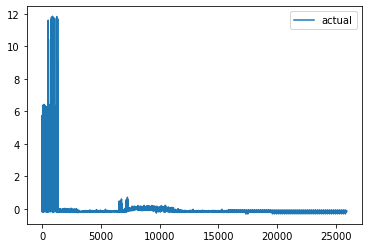

In [ ]:
# Visualize original data
plt.plot(actual_data_client, label="actual")
plt.legend()
plt.plot()

[]

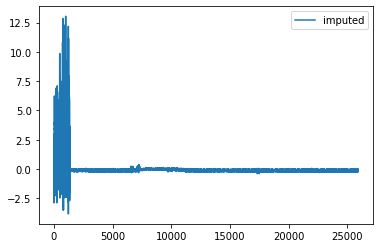

In [ ]:
# Visualize original data
plt.plot(imputed_data_client, label="imputed")
plt.legend()
plt.plot()

### Store the imputed data for FedLSTM

In [ ]:
# Function to store the imputed data
def store_imputed_data(n_users, L, dim, missing_percentage, imputed_data):
    results_path = f"../imputed_data/"
    file_name = f"numuser_{n_users}_L_{L}_dim_{dim}_missingPercentage_{missing_percentage}"
    file_path = os.path.join(results_path, file_name)
    np.save(file_path, imputed_data)

In [ ]:
# Store imputed data
store_imputed_data = False
if store_imputed_data:
    store_imputed_data(n_users=20, L=80, dim=40, missing_percentage=40, imputed_data=imputed_data_flatten_np)